In [1]:
import sys
sys.path.append('../src')
import os
import torch
import numpy as np
import scipy.io
import pandas as pd
import librosa as lr
import seaborn as sns
import librosa.display as lrd
import matplotlib as mpl
import matplotlib.pyplot as plt

from vsdataset import VocalSetDataset
from utils import get_preprocessing, get_dataloader

In [4]:
def get_model_name(z,b,x_dim,h,run):
    layout = [
        ('model={:s}',  'vae'),
        ('z={:02d}',  z),
        ('b={:0.4f}', b),
        ('f={:02d}', x_dim),
        ('h={:04d}', h),
        ('run={:04d}', run),
    ]
    model_name = '_'.join([t.format(v) for (t, v) in layout])
    return model_name

def create_ckpt_path(z,b,x_dim,h,run):
    model_name = get_model_name(z,b,x_dim,h,run)
    ckpt_path = f'./checkpoints/{model_name}'
    return ckpt_path

In [5]:
# plotting params
fs = 24

### Instantiate Dataset

In [2]:
preproc_train = get_preprocessing(train=True, log_transform=True)
sr = 44100
duration=1
data_dir = '/Volumes/GoogleDrive/My Drive/Research/VQM-VAE/data/VocalSet/train/split_1s'
meas_file = 'voicelab_results.xlsx'
VS = VocalSetDataset(data_dir, meas_file, sr=sr, duration=1, transform=preproc_train)
sn, sample, labels = VS[0]
print(f'Num samples in train: {len(VS)}')

Applying mean-normalization to all features
VSD initialized


In [22]:
preproc_train

Compose(
    MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)
    AmplitudeToDB()
)

Input Audio Sample Dimensions: torch.Size([1, 80, 173])


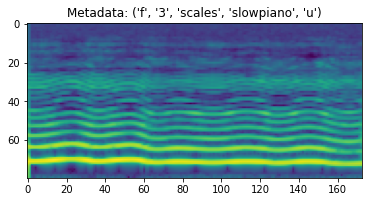

VQMs:
{'subharmonic-to-harmonic ratio': -0.5463653508399458, 'Subharmonic Mean Pitch': 0.6281454780621042, 'Harmonics to Noise Ratio': 1.802756880081697, 'Local Jitter': -0.36873387793552265, 'localdb_shimmer': -0.5953110382444771, 'cpp': -0.08015346487474981, 'Spectral Tilt': -0.27323823082101173, 'Centre of Gravity': -0.1304578038029452, 'Standard Deviation': -0.464112928318626, 'Skewness': -0.2564573283128651, 'Band Energy Difference': 2.269132550584849, 'Band Density Difference': 2.2691325505848488}


In [37]:
# get sample audio and measurements
_, sample, label = VS[200]
print(f'Input Audio Sample Dimensions: {sample.shape}')
plt.imshow(sample.squeeze(0).flipud())
plt.title(f'Metadata: {label[2]}')
plt.show()
print(f'VQMs:\n{label[0]}')

In [83]:
# test dataloader
dl_train = get_dataloader(VS, batch_size=16,shuffle=True)
batch = next(iter(dl_train))
sample_clean_batch = batch[0]
sample_noisy_batch = batch[1]
labels_batch = batch[2]
vqms_batch = labels_batch[0]
freqs_batch = labels_batch[1]
metadata_batch = pd.DataFrame(columns=['Gender','ID','Phrase','Technique','Vowel'])
metadata_batch['Gender'] = pd.Series(labels_batch[2][0])
metadata_batch['ID'] = pd.Series(labels_batch[2][1])
metadata_batch['Phrase'] = pd.Series(labels_batch[2][2])
metadata_batch['Technique'] = pd.Series(labels_batch[2][3])
metadata_batch['Vowel'] = pd.Series(labels_batch[2][4])
print(metadata_batch)

   Gender  ID     Phrase  Technique Vowel
0       f   5  arpeggios   straight     o
1       m   9       long     trillo     e
2       m   1       dona    vibrato     N
3       f   3     scales  slowforte     o
4       m  11     scales  slowforte     i
5       f   5     scales  fastforte     u
6       f   1       long      trill     a
7       f   3     scales   vocalfry     u
8       m  11       dona    vibrato     N
9       m   2       long     trillo     a
10      m   6       dona    vibrato     N
11      m   8       long      trill     i
12      m   7     scales  slowforte     e
13      f   9     scales  slowpiano     o
14      f   4  arpeggios  slowpiano     o
15      f   5     scales       belt     a


AttributeError: 'QuadMesh' object has no property 'win_length'

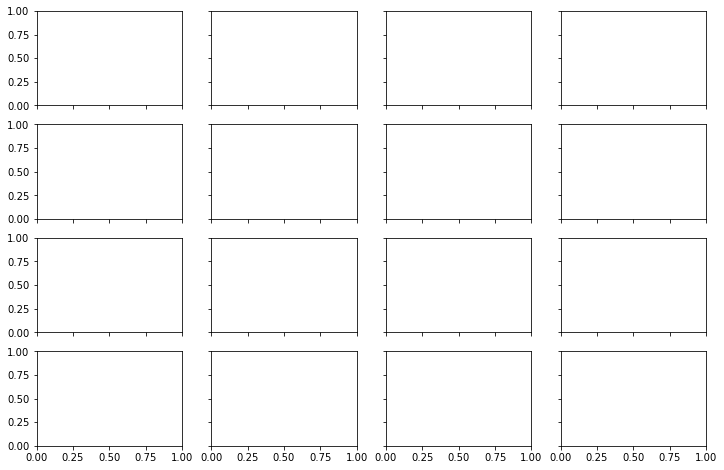

In [86]:
fig, axs = plt.subplots(4, 4, figsize=(12, 8), sharex='col', sharey='row')

for x, title, ax in zip(sample_clean_batch, list(range(16)), axs.flatten()):
    y = lr.amplitude_to_db(np.abs(x.numpy()), ref=1)
    print()
    lrd.specshow(y[0], ax=ax, cmap='magma', sr=sr, win_length=1024, hop_length=256, x_axis='s', y_axis='mel')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title, y=1.0, pad=-14, color='k')
fig.tight_layout()
plt.show()

# Dataset Statistics

### Visualize Measurement Distributions

In [17]:
#normalized data stored in class dataframe
# nhist = VS.df.hist(bins=100,figsize=(20, 18))

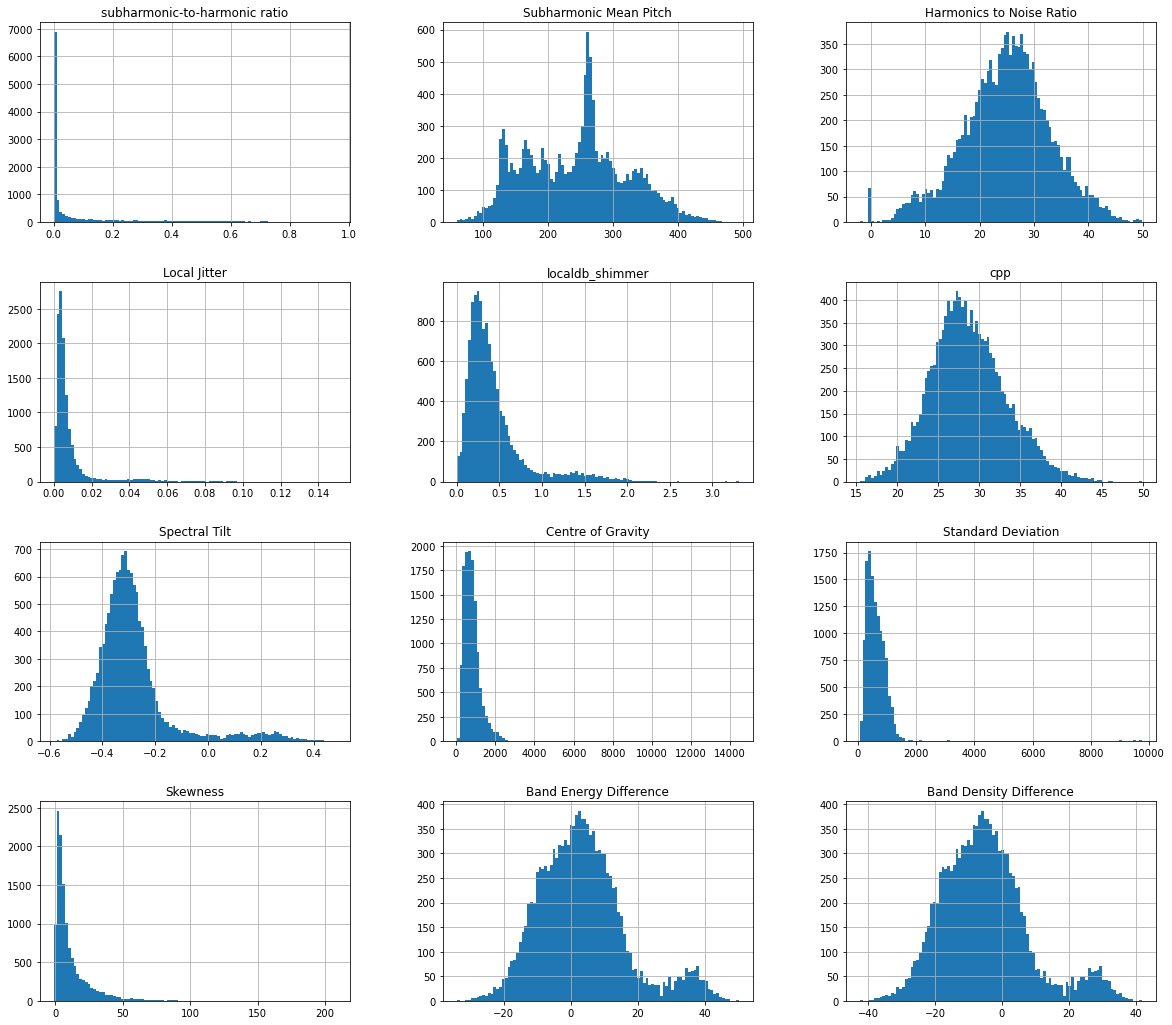

In [18]:
# call this func to get unnormalized features, these are not reset to the class DF itself
dfo = VS._unnormalize_features()
ohist = dfo.hist(bins=100,figsize=(20, 18))

subharmonic-to-harmonic ratio      0.104562
Subharmonic Mean Pitch           244.073829
Harmonics to Noise Ratio          24.909381
Local Jitter                       0.008154
localdb_shimmer                    0.429770
cpp                               28.675635
Spectral Tilt                     -0.282427
Centre of Gravity                856.828561
Standard Deviation               688.743669
Skewness                          10.877666
Band Energy Difference             3.434600
Band Density Difference           -5.016380
dtype: float64

# PCA Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
max_components = len(VS.df.columns)

X = VS.df.to_numpy()
X.shape

(12531, 12)

In [ ]:
pcas = []
var_exp = []
for i in range(2,max_components):
    pca = PCA(n_components=i)
    pca.fit(X)
    Y = pca.transform(X)
    Xhat = pca.inverse_transform(Y)
    mse = mean_squared_error(X, Xhat)
    var_exp.append(np.sum(pca.explained_variance_ratio_))
    pcas.append([pca, mse])
    print(f'Principal Components: {i}, MSE: {mse:.06f}')

Principal Components: 2, MSE: 0.510099
Principal Components: 3, MSE: 0.358713
Principal Components: 4, MSE: 0.255871
Principal Components: 5, MSE: 0.172455
Principal Components: 6, MSE: 0.120891
Principal Components: 7, MSE: 0.072650
Principal Components: 8, MSE: 0.037191
Principal Components: 9, MSE: 0.019288
Principal Components: 10, MSE: 0.008821
Principal Components: 11, MSE: 0.000000


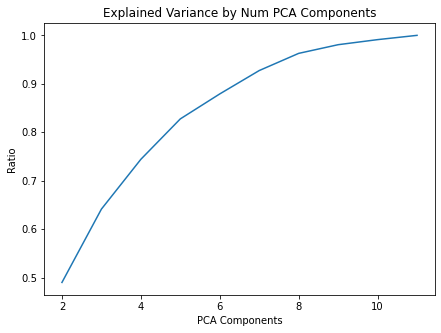

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(2,max_components), var_exp)
plt.title('Explained Variance by Num PCA Components')
plt.ylabel('Ratio')
plt.xlabel('PCA Components')
plt.show()

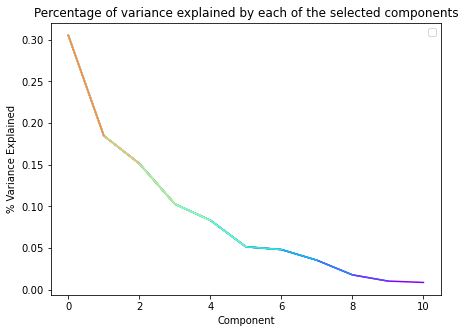

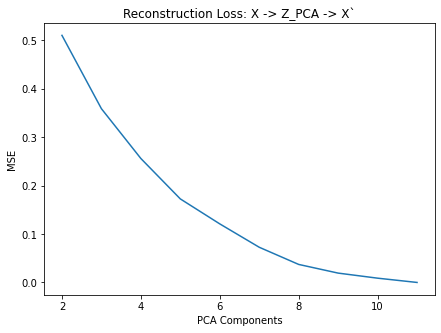

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, max_components))
plt.figure(figsize=(7,5))

mse = []
for i,v in enumerate(list(reversed(pcas))):
    pca = v[0]
    mse.append(v[1])
    plt.plot(pca.explained_variance_ratio_, color=colors[i])
mse = list(reversed(mse))

plt.xlabel('Component')
plt.ylabel('% Variance Explained')
plt.legend(reversed(range(2,max_components)))
plt.title('Percentage of variance explained by each of the selected components')
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(2,max_components), mse)
plt.title('Reconstruction Loss: X -> Z_PCA -> X`')
plt.ylabel('MSE')
plt.xlabel('PCA Components')
plt.show()

In [ ]:
#get label array
# creating instance of labelencoder
labelencoder = LabelEncoder()

labels = [VS._get_sample_labels(VS._get_sample_name(i)) for i in range(X.shape[0])]
gender = [l[0] for l in labels]
gender_cat = labelencoder.fit_transform(gender)
sid = [int(l[1]) for l in labels]
phrase = [l[2] for l in labels]
phrase_cat = labelencoder.fit_transform(phrase)
technique = [l[3] for l in labels]
technique_cat = labelencoder.fit_transform(technique)
vowel = [l[4] for l in labels]
vowel_cat = labelencoder.fit_transform(vowel)

# define the colormap
# cmap = plt.cm.jet
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # create the new map
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

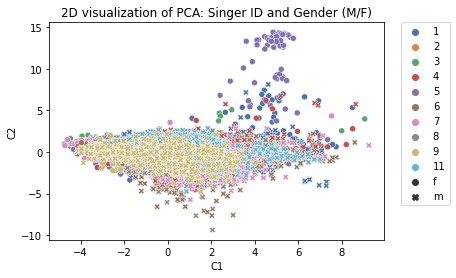

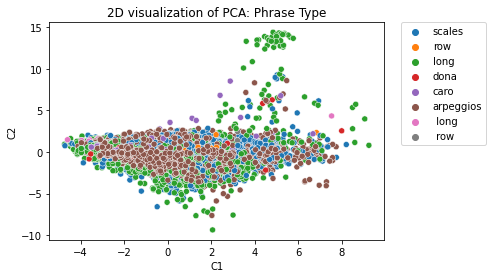

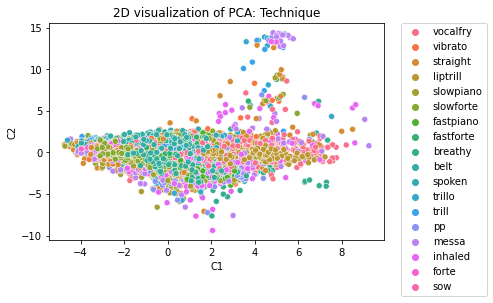

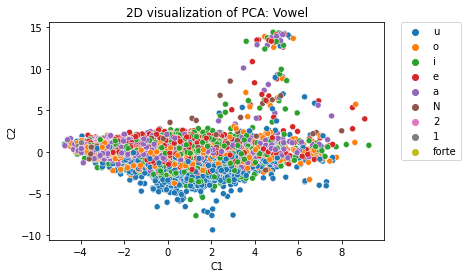

In [ ]:
# 2D visualization of PCA

import seaborn as sns

pca = PCA(n_components=2)
pca.fit(X)
Y = pca.transform(X)

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=sid, legend="full", style=gender, palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Singer ID and Gender (M/F)')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=phrase, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Phrase Type')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=technique, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Technique')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=vowel, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Vowel')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

# Simple AE

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

In [ ]:
X = VS.df.to_numpy()
X.shape

(12531, 12)

In [ ]:
# Shape of input and latent variable
n_input = X.shape[1]

# Encoder structure
h_dim = 64

# result storage
aes = []

In [ ]:
for z_dim in range(2,n_input+1):
    ae = MLPRegressor(hidden_layer_sizes = (h_dim, h_dim, z_dim, h_dim, h_dim), 
                       activation = 'tanh', 
                       solver = 'adam', 
                       learning_rate_init = 0.001, 
                       max_iter = 1000, 
                       tol = 0.0000001, 
                       validation_fraction=0.15)
    ae.fit(X, X)
    print(f'\nz-dim: {z_dim}, best loss: {ae.best_loss_}, n_iters: {ae.n_iter_}')
    aes.append(ae)


z-dim: 2, best loss: 0.0716027023857918, n_iters: 546

z-dim: 3, best loss: 0.04385973215387766, n_iters: 436

z-dim: 4, best loss: 0.026978244647821756, n_iters: 428

z-dim: 5, best loss: 0.014882763528806436, n_iters: 483

z-dim: 6, best loss: 0.009064543488361838, n_iters: 330

z-dim: 7, best loss: 0.005171333161113961, n_iters: 275

z-dim: 8, best loss: 0.003288196964594693, n_iters: 245

z-dim: 9, best loss: 0.0016584586363578742, n_iters: 337

z-dim: 10, best loss: 0.0009971208602247194, n_iters: 236

z-dim: 11, best loss: 0.0003641603497233276, n_iters: 149

z-dim: 12, best loss: 0.0003386068514361359, n_iters: 120


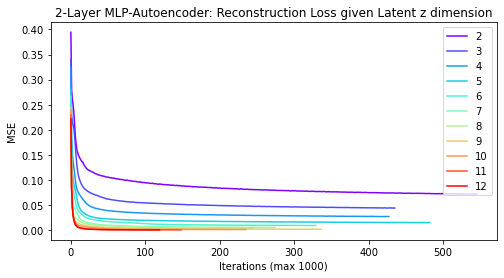

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(aes)))
plt.figure(figsize=(8,4))
mse_ae = []
for i,ae in enumerate(aes):
    plt.plot(ae.loss_curve_, color=colors[i])
    mse_ae.append(ae.best_loss_)
plt.xlabel('Iterations (max 1000)')
plt.ylabel('MSE')
plt.legend(range(2,n_input+1))
plt.title('2-Layer MLP-Autoencoder: Reconstruction Loss given Latent z dimension')
plt.show()

# plt.figure(figsize=(7,5))
# plt.plot(range(2,13), mse_ae)
# plt.title('Best Reconstruction Loss: X -> Z -> X`')
# plt.ylabel('MSE')
# plt.xlabel('dim(Z)')
# plt.show()

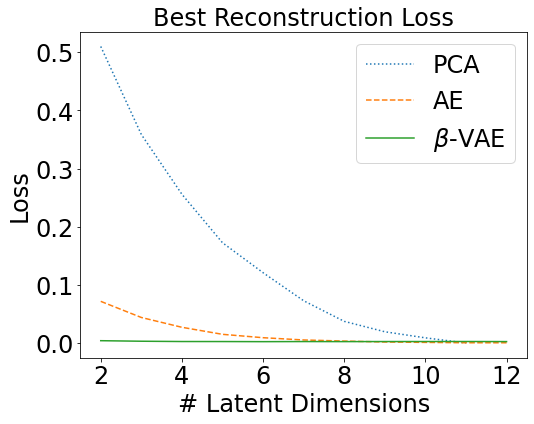

In [ ]:
Z = range(2,13)
b = 0.01 #[0.1000, 0.0100, 0.0010]
f = x_dim
H = 64

best_vae_loss = []
for z in Z:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        best_vae_loss.append(train_loss.min())
    except:
        print('model not found')
        pass

# print(best_vae_loss)

plt.figure(figsize=(8,6))
plt.plot(range(2,max_components), mse, ':')
plt.plot(range(2,n_input+1), mse_ae, '--')
plt.plot(range(2,len(best_vae_loss)+2), best_vae_loss)
plt.title('Best Reconstruction Loss', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.xlabel('# Latent Dimensions', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(['PCA','AE',r'$\beta$-VAE'], fontsize=fs)
plt.show()

In [ ]:
# visualize 2d z space
reg = aes[0] #z=2
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
#     latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

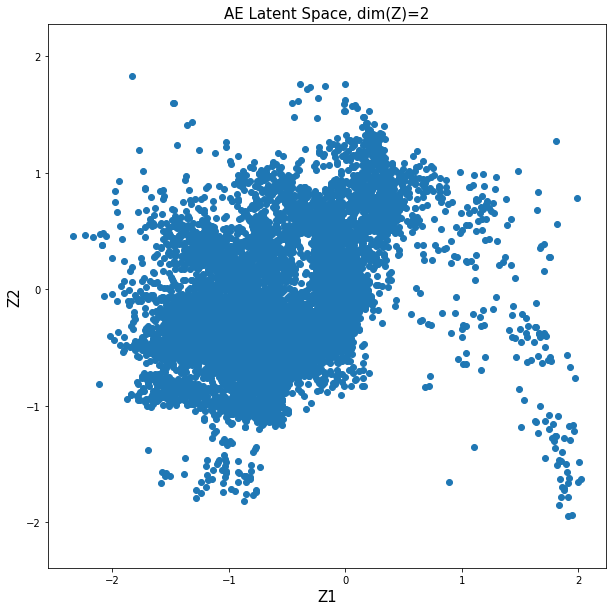

In [ ]:
test_x = X
test_latent = encoder(test_x)

plt.figure(figsize = (10,10))
plt.scatter(test_latent[:,0], test_latent[:,1])
plt.title('AE Latent Space, dim(Z)=2', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.axis('equal')
plt.show()

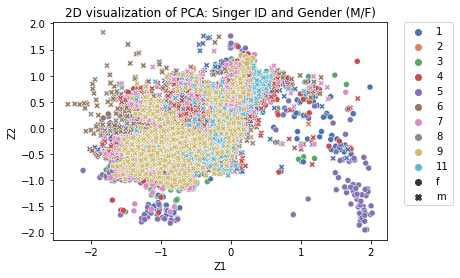

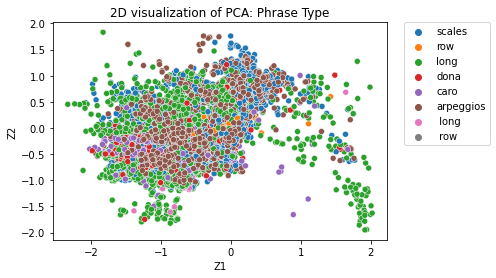

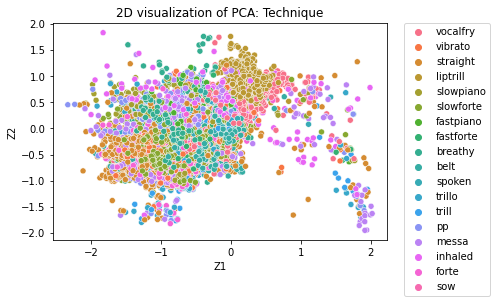

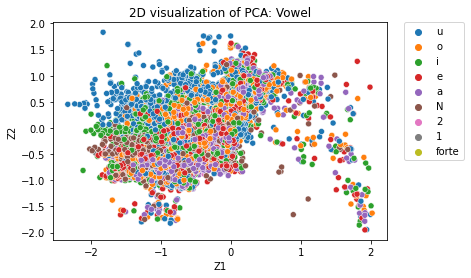

In [ ]:
Y = test_latent

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=sid, legend="full", style=gender, palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Singer ID and Gender (M/F)')
plt.xlabel('Z1'); plt.ylabel('Z2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=phrase, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Phrase Type')
plt.xlabel('Z1'); plt.ylabel('Z2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=technique, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Technique')
plt.xlabel('Z1'); plt.ylabel('Z2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=vowel, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of PCA: Vowel')
plt.xlabel('Z1'); plt.ylabel('Z2')
plt.show()

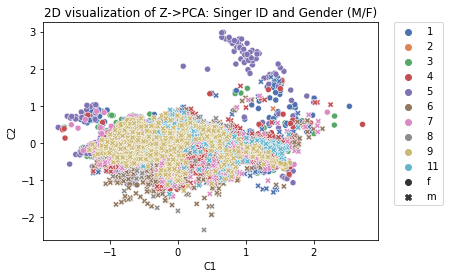

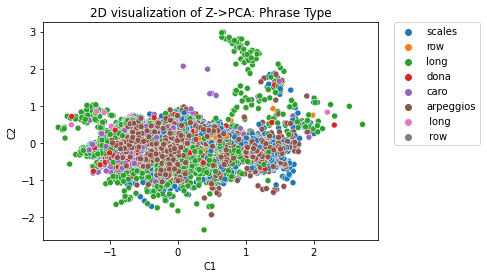

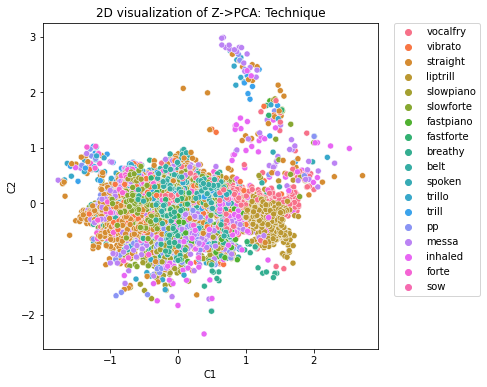

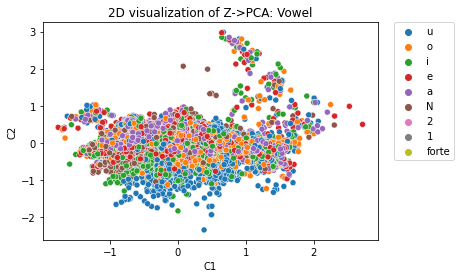

In [ ]:
pca = PCA(n_components=2)
pca.fit(test_latent)
Y = pca.transform(test_latent)

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=sid, legend="full", style=gender, palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of Z->PCA: Singer ID and Gender (M/F)')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=phrase, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of Z->PCA: Phrase Type')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=technique, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of Z->PCA: Technique')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=vowel, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2D visualization of Z->PCA: Vowel')
plt.xlabel('C1'); plt.ylabel('C2')
plt.show()

# VAE

### comparison between hyperparameters

### number of hidden layers in enc/dec

model not found
model not found
model not found


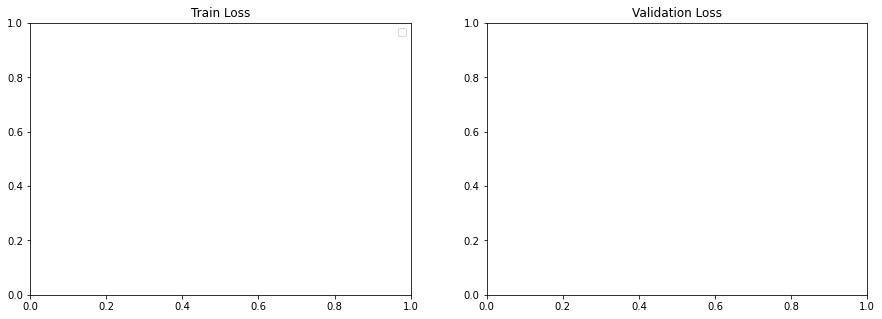

In [ ]:
lr = 1e-4
batch_size = 200

Z = 4
B = 0.01
f = x_dim
H = 16
L = [1,2,3]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
leg = []
i = 0
for run in L:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,h,run)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}_l={run}')
    except:
        print('model not found')
        pass
plt.title('Train Loss')
plt.legend(leg)

plt.subplot(1,2,2)
leg = []
i = 0
for run in L:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,h,run)
        valid_loss = np.load(os.path.join(ckpt_path,'valid-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(valid_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}_l={run}')
    except:
        pass
plt.title('Validation Loss')
plt.show()        

### num units per layer, one hidden layer in enc/dec

model not found


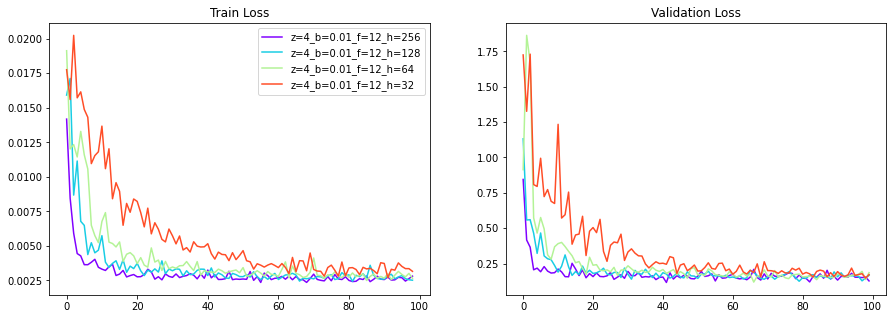

In [ ]:
lr = 1e-4
batch_size = 200

z = 4 #[10,8,6,4,2]
b = .01 #[0.1000, 0.0100, 0.0010]
f = x_dim
H = [256,128,64,32,16] #[16,32,64,128,256]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
leg = []
i = 0
for h in H:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,h,0)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={h}')
    except:
        print('model not found')
        pass
plt.title('Train Loss')
plt.legend(leg)

plt.subplot(1,2,2)
leg = []
i = 0
for h in H:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,h,0)
        valid_loss = np.load(os.path.join(ckpt_path,'valid-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(valid_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={h}')
    except:
        pass
plt.title('Validation Loss')
plt.show()        

### varying z

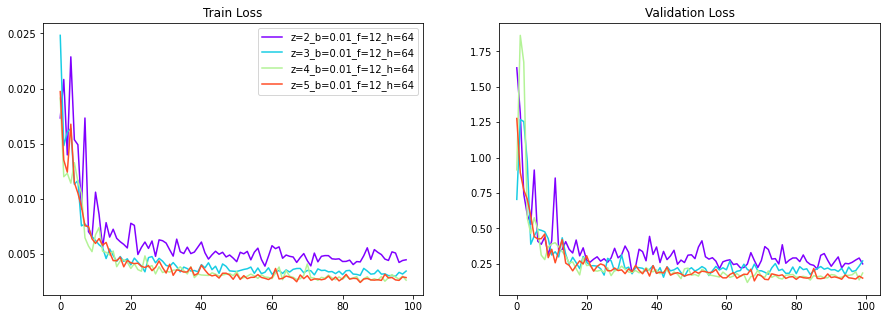

In [ ]:
lr = 1e-4
batch_size = 200

Z = [2,3,4,5]
b = 0.01 #[0.1000, 0.0100, 0.0010]
f = x_dim
H = 64

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
leg = []
i = 0
for z in Z:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        print('model not found')
        pass
plt.title('Train Loss')
plt.legend(leg)

plt.subplot(1,2,2)
leg = []
i = 0
for z in Z:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        valid_loss = np.load(os.path.join(ckpt_path,'valid-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(valid_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        pass
plt.title('Validation Loss')
plt.show()        

### varying beta

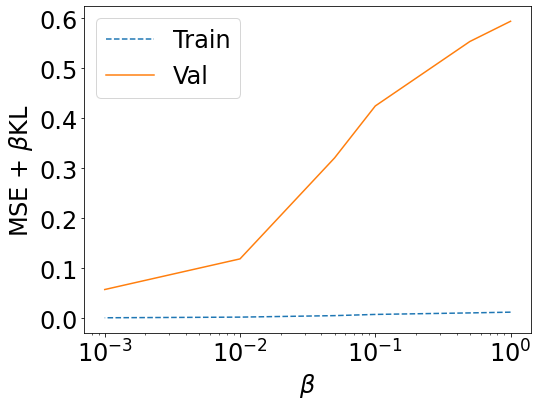

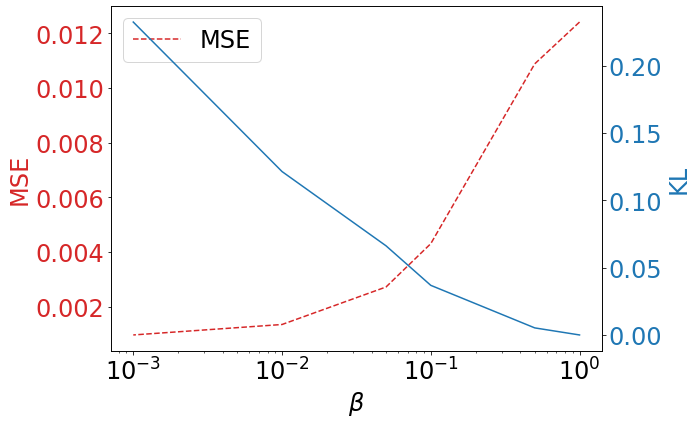

In [ ]:
lr = 1e-4
batch_size = 200


B = [1, 0.5, 0.1, 0.05, 0.01, 0.001]
f = x_dim
H = 64

################################ Z = 12
z = 4

# fig = plt.figure(figsize=(15,5))

# plt.subplot(1,2,1)
# leg = []
# i = 0

beta = []
train_beta = []
kld_beta = []
rec_beta = []
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
#         print(ckpt_path)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        kld = np.load(os.path.join(ckpt_path,'kld_model-00100.npy'), allow_pickle=True)
#         print(kld.shape)
        rec_loss = np.load(os.path.join(ckpt_path,'rec-loss_model-00100.npy'), allow_pickle=True)
#         print(rec_loss.shape)
        
        train_beta.append(train_loss.min())
#         print(kld[-1])
        kld_beta.append(kld[-1])
        rec_beta.append(rec_loss.min())
        beta.append(b)
#         plt.plot(train_loss, color=colors[3*i]); i+=1;
#         leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        print('model not found')
        pass
# plt.title('Train Loss')
# plt.legend(leg)

# plt.subplot(1,2,2)
# leg = []
# i = 0
valid_beta = []
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        valid_loss = np.load(os.path.join(ckpt_path,'valid-loss_model-00100.npy'), allow_pickle=True)
        valid_beta.append(valid_loss.min())
#         plt.plot(valid_loss, color=colors[3*i]); i+=1;
#         leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        pass
# plt.title('Validation Loss')
# plt.show()

fig1 = plt.figure(figsize=(8,6))

plt.plot(beta,train_beta,'--')
plt.plot(beta,valid_beta)
plt.xscale('log')
plt.legend(['Train','Val'], fontsize=fs)
plt.xlabel(r'$\beta$', fontsize=fs)
plt.ylabel(r'MSE + $\beta$KL', fontsize=fs)
plt.title('')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()


fig, ax1 = plt.subplots(figsize=(10,6))

color='tab:red'
ax1.set_xlabel(r'$\beta$', fontsize=fs)
ax1.set_xscale('log')
ax1.set_ylabel('MSE', color=color, fontsize=fs)
ax1.plot(beta, rec_beta, '--', color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=fs)
ax1.tick_params(axis='x', labelsize=fs)
plt.legend(['MSE'], fontsize=fs)

ax2 = ax1.twinx()
color='tab:blue'
ax2.set_ylabel('KL', color=color, fontsize=fs)  # we already handled the x-label with ax1
ax2.plot(beta, kld_beta, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=fs)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

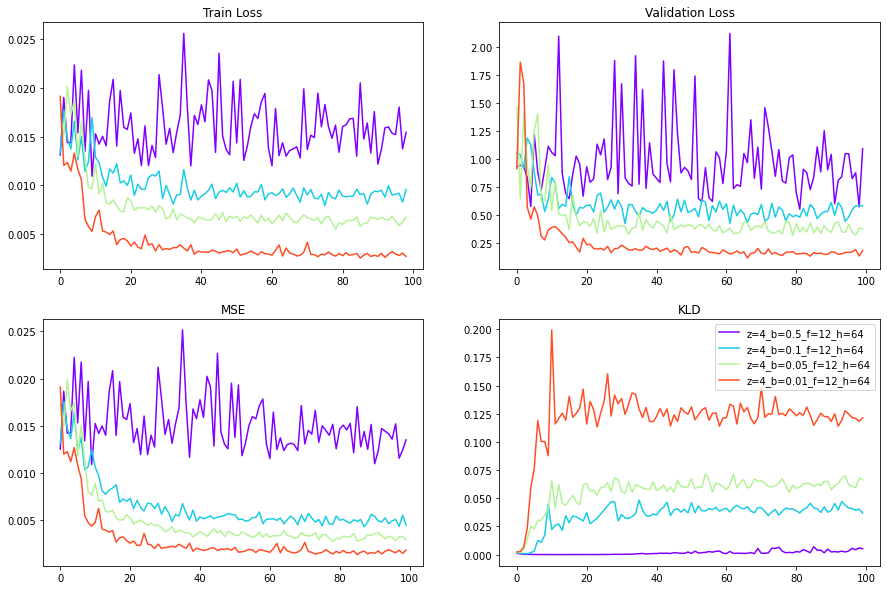

In [ ]:

################################## Z = 4
z = 4
B = [0.5, 0.1, 0.05, 0.01]


fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
leg = []
i = 0
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        train_loss = np.load(os.path.join(ckpt_path,'train-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        print('model not found')
        pass
plt.title('Train Loss')

plt.subplot(2,2,2)
leg = []
i = 0
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        valid_loss = np.load(os.path.join(ckpt_path,'valid-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(valid_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        pass
plt.title('Validation Loss')

plt.subplot(2,2,3)
leg = []
i = 0
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        train_loss = np.load(os.path.join(ckpt_path,'rec-loss_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        print('model not found')
        pass
plt.title('MSE')


plt.subplot(2,2,4)
leg = []
i = 0
for b in B:
    try:
        ckpt_path = create_ckpt_path(z,b,x_dim,H,0)
        train_loss = np.load(os.path.join(ckpt_path,'kld_model-00100.npy'), allow_pickle=True)
        plt.plot(train_loss, color=colors[3*i]); i+=1;
        leg.append(f'z={z}_b={b}_f={f}_h={H}')
    except:
        print('model not found')
        pass
plt.title('KLD')
plt.legend(leg)
plt.show()



## Chosen Hyperparams based on above analyses:

L = 1,

H = 64,

Z = 4, aligning with the 4 phonation modes and allowing for later integration of labels for SSVAE

beta = 0.01


Also, we see that if we choose beta << 1 and z = input_dim, we can get near perfect reconstruction.  This means that we probably don't have a gaussian prior that we are sampling from, and we have no compression, but we can indeed the almost "perfect" reconstruction scenario and work back from there.

On the contrary, it doesn't seem like we can get the VAE to train if we have Beta=1. If time, plot and keep track of KLD

## TSNE Visualizations of VAE Latent Space